In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from tqdm import tqdm

In [35]:
stations = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/IEA_PVPS_europe.zarr')
stations

<xarray.Dataset>
Dimensions:       (station_name: 10, time: 3156062)
Coordinates:
    elevation     (station_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude      (station_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude     (station_name) float32 dask.array<chunksize=(1,), meta=np.ndarray>
  * station_name  (station_name) <U3 'CAB' 'CAR' 'CEN' ... 'TAB' 'TOR' 'VIS'
  * time          (time) datetime64[ns] 2015-01-01 ... 2020-12-31T17:01:00
Data variables:
    Azim          (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    DIF           (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    DNI           (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    Elev          (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    GHI           (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    GHIcalc       (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>
    Kc            (station_name, time) float32 dask.array<chunksize=(1, 3156062), meta=np.ndarray>

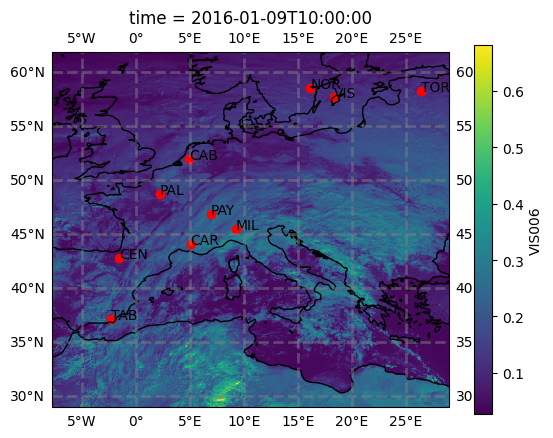

In [48]:
hrseviri = xarray.open_zarr('/scratch/snx3000/acarpent/EumetsatData/SEVIRI_WGS_2016-2022_RSS.zarr')

proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.latitude.values
lon = stations.longitude.values
name = stations.station_name.values
axis.scatter(x=lon, y=lat, c='r')
for i, txt in enumerate(name):
    axis.annotate(txt, (lon[i], lat[i]))

hrseviri.VIS006.isel(time = 1000).plot.imshow(ax=axis, transform = proj)



In [49]:
hrseviri

<xarray.Dataset>
Dimensions:      (time: 222290, y: 658, x: 736)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 ... 2022-12-31T23:45:00
  * x            (x) float64 -7.775 -7.725 -7.675 -7.625 ... 28.88 28.93 28.98
  * y            (y) float64 28.98 29.03 29.08 29.12 ... 61.68 61.73 61.78 61.83
Data variables:
    IR_016       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_039       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_087       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_097       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_108       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_120       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_134       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS006       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS008       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_062       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_073       (time, y, x) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    spatial_ref  int64 ...

In [ ]:

lat = stations.sel(station_name='CAB').latitude.data
lon = stations.sel(station_name='CAB').longitude.values
ilat = (np.abs(hrseviri.y - lat)).argmin().values
ilon = (np.abs(hrseviri.x - lon)).argmin().values

patch_size = 31
hpatch = int(np.floor(patch_size/2))

CAB_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch))
CAB_slice = CAB_slice.chunk({'time':10000})

for var in CAB_slice:
    CAB_slice[var].encoding['chunks'] = {'time':10000}

CAB_slice.to_zarr('/scratch/snx3000/kschuurm/DATA/HRSEVIRI_CAB.zarr', mode='w')


In [ ]:
CAB_slice = xarray.open_zarr('/scratch/snx3000/kschuurm/DATA/HRSEVIRI_CAB.zarr')

In [ ]:
stations.time

In [ ]:
CAB_slice = CAB_slice.dropna(dim='time')

In [ ]:
print('time slices:', len(CAB_slice.time)) #hrseviri should be full minute 
timenotnan = set(CAB_slice.time.values).intersection(set(stations.time.values))
timenotnan = np.sort(np.array(list(timenotnan)))
print('intersecting slices:', len(timenotnan))

In [ ]:
rolling = stations.sel(station_name='CAB').GHI.rolling(time=12,center=False).mean().dropna(dim='time')
# rolling average of 12 minutes (seviri takes 12 min to create an image
# time index is the right most index

from datetime import timedelta

rolling['time'] = rolling['time'] - np.timedelta64(12, 'm')

timenotnan = set(rolling.time.values).intersection(set(timenotnan))

In [ ]:
timenotnan = np.sort(np.array(list(timenotnan)))

In [ ]:
CAB_slice.VIS008.sel(time= timenotnan[0])

In [38]:
def create_collocated_zarr(station_name, patch_size=31, time_window=12):
    
    SAVE_PATH = f'/scratch/snx3000/kschuurm/ZARR/{station_name}/'
    
    # locate the collocated point of seviri with the station
    lat = stations.sel(station_name=station_name).latitude.data
    lon = stations.sel(station_name=station_name).longitude.values
    ilat = (np.abs(hrseviri.y - lat)).argmin().values
    ilon = (np.abs(hrseviri.x - lon)).argmin().values

    hpatch = int(np.floor(patch_size/2))

    station_slice = hrseviri.isel(y=slice(ilat-hpatch, ilat + hpatch +1), x=slice(ilon-hpatch, ilon+hpatch))
    station_slice = station_slice.chunk({'time':10000})

    for var in station_slice:
        station_slice[var].encoding['chunks'] = {'time':10000}
    
    # Write the subset to a zarr dataset before performing the next operations
    station_slice.to_zarr(SAVE_PATH + f'SEVIRI_{station_name}.zarr', mode='w')   
    station_slice = xarray.open_zarr(SAVE_PATH + f'SEVIRI_{station_name}.zarr')
    
    # drop time slices with missing information
    station_slice = station_slice.dropna(dim='time')
    
    rolling = stations.sel(station_name=station_name) \
        .GHI.rolling(time=time_window,center=False) \
        .mean().dropna(dim='time')
    # rolling average of X minutes (seviri takes X min to create an image, RSS=5min, normal full disk 12min)
    # mean becomes a nan if a single nan value is encountered in GHI
    
    # mean index is the right most index -> convert to left most index to relate to hrseviri
    rolling['time'] = rolling['time'] - np.timedelta64(time_window, 'm')
        
    print('time slices SEVIRI (not nan):', len(station_slice.time.values)) #hrseviri should be full minute 
    timenotnan = set(rolling.time.values).intersection(set(station_slice.time.values))

    timenotnan = np.sort(np.array(list(timenotnan)))
    print('intersecting station with seviri slices:', len(timenotnan))
    
    np.save( SAVE_PATH + 'timeidxnotnan.npy', timenotnan)
    
    print()
    print(f'        STATION {station_name} DONE         ')
    print()

In [47]:

for nm in tqdm(station.station_names.values):
    print(nm)
    create_collocated_zarr(nm)
   

CEN
time slices SEVIRI (not nan): 162050
intersecting station with seviri slices: 29840

        STATION CEN DONE         

MIL
time slices SEVIRI (not nan): 162051
intersecting station with seviri slices: 31617

        STATION MIL DONE         

NOR
time slices SEVIRI (not nan): 162055
intersecting station with seviri slices: 43344

        STATION NOR DONE         

PAL
time slices SEVIRI (not nan): 162054
intersecting station with seviri slices: 42312

        STATION PAL DONE         

PAY
time slices SEVIRI (not nan): 162051
intersecting station with seviri slices: 35445

        STATION PAY DONE         

TAB
time slices SEVIRI (not nan): 162048
intersecting station with seviri slices: 57070

        STATION TAB DONE         

TOR
time slices SEVIRI (not nan): 162055
intersecting station with seviri slices: 36107

        STATION TOR DONE         

VIS
time slices SEVIRI (not nan): 162056
intersecting station with seviri slices: 38143

        STATION VIS DONE         



# PLAYGROUND


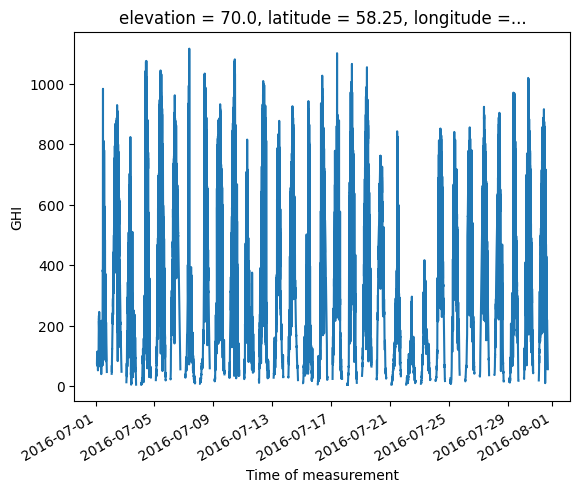

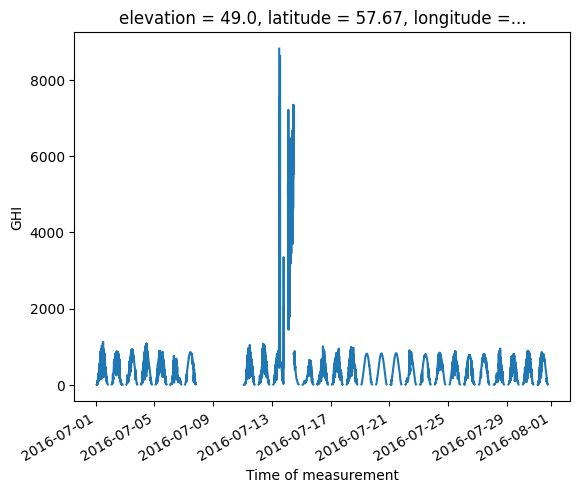

In [46]:

from datetime import datetime

for nm in stations.station_name.values[-2:]:
    plt.figure()
    stations.sel(station_name=nm)['GHI'].sel(time=slice(datetime(2016, 7,1), datetime(2016,8,1))).plot()